Process: Input -> Preprocess and have only 25 + 4 + 1 attributes -> Convert the 25 attributes into x using PCA and then into 1 using LDA. Reconstruct the dataset with 6 attributes: srcip, sport, dstip, dsport, dimensionalityReducedAttribute, label -> Construct adjacency matrix for the train , and for the label. Pass this adjacency matrix to GCN, GAT, and GraphSAGE in parallel. Repeat the same input processing for test matrix. Test the model, store each prediction, and then outline a classification report with AUC score.

## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


## Dataset Loading

In [5]:
train = pd.read_csv(r'D:\Project Phase II\Dataset\train.csv',encoding='cp1252')
test = pd.read_csv(r'D:\Project Phase II\Dataset\test.csv',encoding='cp1252')

NameError: name 'pd' is not defined

In [47]:
authortest = pd.read_csv(r'D:\Project Phase II\Dataset\UNSW_NB15_testing-set.csv',encoding='cp1252')

## Dataset preprocessing

In [4]:
todrop = ['sloss', 'dloss','stcpb', 'dtcpb', 'trans_depth', 'Stime', 'Ltime','ct_flw_http_mthd', 
        'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
        'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat']
        
reducedTrain = train.drop(todrop, axis = 1)
reducedTest = test.drop(todrop, axis = 1)
reducedTrain = reducedTrain.drop_duplicates()
reducedTest = reducedTest.drop_duplicates()

In [5]:
trainAttributes = reducedTrain.drop(['srcip','sport','dstip','dsport','Label'], axis = 1)
trainLabel = reducedTrain['Label']
testAttributes = reducedTest.drop(['srcip','sport','dstip','dsport','Label'], axis = 1)
testLabel = reducedTest['Label']

In [6]:
train = reducedTrain
test = reducedTest

Author's train-test dataset preprocess

In [48]:
le = LabelEncoder()
authortest['proto'] = le.fit_transform(authortest['proto'])
authortest['state'] = le.fit_transform(authortest['state'])
authortest['service'] = le.fit_transform(authortest['service'])

In [49]:
authortodrop = ['ï»¿id','rate', 'attack_cat', 'is_sm_ips_ports', 'sloss', 'dloss', 'stcpb', 'dtcpb', 'trans_depth',
                'ct_srv_src', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
                'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst']
#Change column names of df
authortest = authortest.rename(columns={'dinpkt':'Dintpkt','djit':'Djit','dload':'Dload','dpkts':'Dpkts','label':'Label','sinpkt':'Sintpkt',
                        'sjit':'Sjit','sload':'Sload', 'spkts':'Spkts','dmean':'dmeansz','response_body_len':'res_bdy_len', 'smean':'smeansz'})
authortest = authortest.drop(authortodrop,axis = 1)
authortest = authortest.drop_duplicates()
authortestAttributes = authortest[trainAttributes.columns]
authortestLabel = authortest['Label']

## Find best dimension for PCA

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


Best n value:  7
Variance Ratio: [9.99480578e-01 5.15418833e-04 1.96223365e-06 1.87098832e-06
 1.24629337e-07 4.48032356e-08 3.44039133e-10]

Second Best n value:  18
Variance Ratio: [9.99480578e-01 5.15418833e-04 1.96223365e-06 1.87098832e-06
 1.24629337e-07 4.48032356e-08 3.44039133e-10 6.71098399e-11
 8.64488787e-12 2.53224963e-12 1.75036884e-12 6.40235312e-13
 2.78614539e-13 9.87091134e-14 3.99781277e-14 8.67243724e-15
 1.13198579e-15 3.95815015e-16]


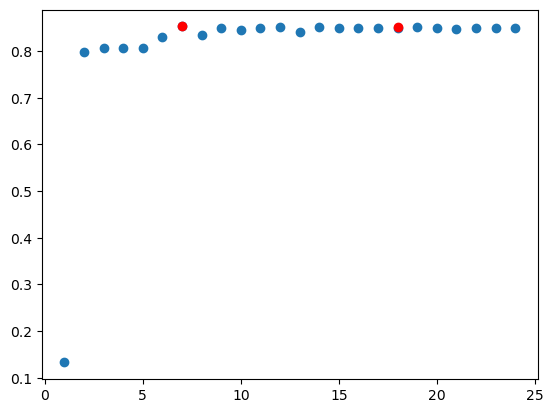

In [18]:
from sklearn.decomposition import PCA
pca_n = []
pca_n_f1 = []
pca_attr = []
for i in range(1,25):
    pca = PCA(n_components = i)
    pca_x_train = pca.fit_transform(trainAttributes)
    pca_x_test = pca.fit_transform(testAttributes)
    pca_attr.append(pca.explained_variance_ratio_)
    # # explained_variance = pca.explained_variance_ratio_
    # print(explained_variance)
    classifier = LogisticRegression()
    classifier.fit(pca_x_train, trainLabel)
    classifier_pred = classifier.predict(pca_x_test)
    pca_n.append(i)
    pca_n_f1.append(f1_score(testLabel,classifier_pred))
    

plt.scatter(x=pca_n, y=pca_n_f1)

best_pca_n = pca_n_f1.index(max(pca_n_f1)) + 1
print('\nBest n value: ',best_pca_n)
print('Variance Ratio:',pca_attr[best_pca_n - 1])
plt.scatter(x=best_pca_n, y=pca_n_f1[best_pca_n - 1], color='red')
pca_n_f1.pop(best_pca_n -1)
sbest_pca_n = pca_n_f1.index(max(pca_n_f1)) + 1
print('\nSecond Best n value: ',sbest_pca_n)
print('Variance Ratio:',pca_attr[sbest_pca_n - 1])
plt.scatter(x=sbest_pca_n, y=pca_n_f1[sbest_pca_n - 1], color='red')
plt.show()

## SVD 


Best n value:  13


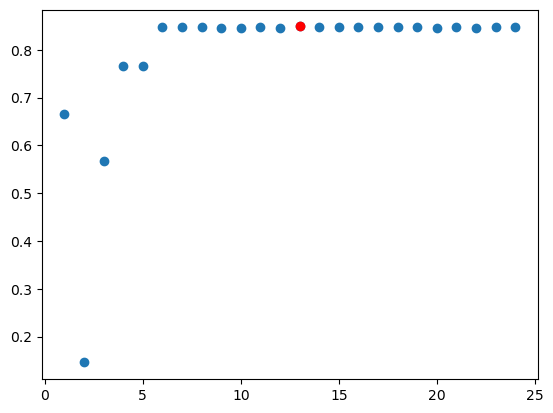

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

svd_n = []
svd_n_f1 = []
for i in range(1,25):
    steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression())]
    pipeline_model = Pipeline(steps=steps)
    cv_res = cross_validate(estimator=pipeline_model,X=trainAttributes,y=trainLabel,n_jobs=-1,cv=10,scoring = 'accuracy',return_train_score = True)
    y_pred = cross_val_predict(estimator=pipeline_model,X=testAttributes,y=testLabel,n_jobs=-1,cv=10)
    svd_n_f1.append(f1_score(testLabel,y_pred))
    svd_n.append(i)

plt.scatter(x=svd_n, y=svd_n_f1)

best_svd_n = svd_n_f1.index(max(svd_n_f1)) + 1
print('\nBest n value: ',best_svd_n)
plt.scatter(x=best_svd_n, y=svd_n_f1[best_svd_n - 1], color='red')
plt.show()

## LDA

Note: LDA can take in upto a maximum of (unique number of classes -1 )in the target variable


Best n value:  1
Variance Ratio: [1.]


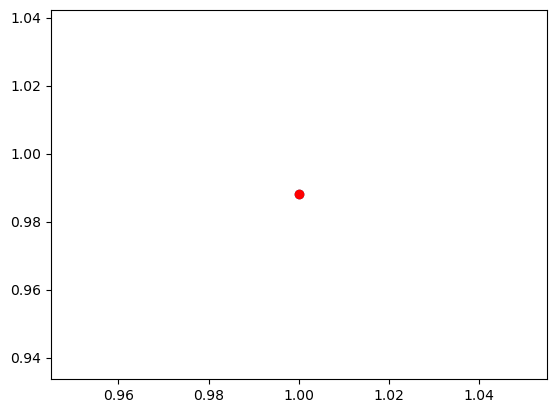

F1 score:  0.987965358227421


In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_n = []
lda_n_f1 = []
lda_attr = []
for i in range(1,2):
    lda = LinearDiscriminantAnalysis(n_components = i)
    lda_x_train = lda.fit_transform(trainAttributes, trainLabel)
    lda_x_test = lda.transform(testAttributes)
    lda_attr.append(lda.explained_variance_ratio_)
    # # explained_variance = pca.explained_variance_ratio_
    # print(explained_variance)
    classifier = LogisticRegression()
    classifier.fit(lda_x_train, trainLabel)
    classifier_pred = classifier.predict(lda_x_test)
    lda_n.append(i)
    lda_n_f1.append(f1_score(testLabel,classifier_pred))
    

plt.scatter(x=lda_n, y=lda_n_f1)

best_lda_n = lda_n_f1.index(max(lda_n_f1)) + 1
print('\nBest n value: ',best_lda_n)
print('Variance Ratio:',lda_attr[best_lda_n - 1])
plt.scatter(x=best_lda_n, y=lda_n_f1[best_lda_n - 1], color='red')
lda_n_f1.pop(best_lda_n -1)
plt.show()
print('F1 score: ',f1_score(testLabel,classifier_pred))

## Test PCA and LDA scores

Use PCA to reduce 25 into 7 dimensions. Then LDA will reduce it to 1. Note: Simply using LDA to map them from 25 attributes to 1 attribute is more effective. Skipping PCA can be considered.

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 7)
pca_x_train = pca.fit_transform(trainAttributes)
pca_x_test = pca.fit_transform(authortestAttributes)


In [50]:
pca_x_train = trainAttributes
pca_x_test = authortestAttributes

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 1)
lda_x_train = lda.fit_transform(pca_x_train, trainLabel)
lda_x_test = lda.transform(pca_x_test)


In [58]:
# List of classifiers to include
import sklearn
import xgboost
import lightgbm
import sklearn.discriminant_analysis
from lazypredict.Supervised import LazyClassifier

#Skip SVM
classifiers = [
 ('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('KNeighborsClassifier',  sklearn.neighbors._classification.KNeighborsClassifier),
 ('LinearDiscriminantAnalysis',  sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
 ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
 ('Perceptron', sklearn.linear_model._perceptron.Perceptron),
 ('QuadraticDiscriminantAnalysis',  sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis),
 ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
 ('StackingClassifier', sklearn.ensemble._stacking.StackingClassifier),
 ('XGBClassifier', xgboost.sklearn.XGBClassifier),
 ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier)]
clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=None,classifiers=classifiers,predictions=True)


In [59]:
#train models using clf 
models,predictions = clf.fit(lda_x_train, lda_x_test, trainLabel, authortestLabel)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


  7%|▋         | 1/15 [00:02<00:29,  2.09s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6656483951467171, 'Balanced Accuracy': 0.5172628461451693, 'ROC AUC': 0.5172628461451693, 'F1 Score': 0.5663958832197289, 'Time taken': 2.0860018730163574}


 13%|█▎        | 2/15 [00:04<00:28,  2.18s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.5607090611823423, 'Balanced Accuracy': 0.5704318841762752, 'ROC AUC': 0.5704318841762752, 'F1 Score': 0.5728474195137573, 'Time taken': 2.252000331878662}
{'Model': 'BernoulliNB', 'Accuracy': 0.470054212202048, 'Balanced Accuracy': 0.5953712600071269, 'ROC AUC': 0.5953712600071269, 'F1 Score': 0.41758805349760697, 'Time taken': 0.05899548530578613}


 27%|██▋       | 4/15 [00:04<00:10,  1.07it/s]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.5538895103691592, 'Balanced Accuracy': 0.5698149469218265, 'ROC AUC': 0.5698149469218265, 'F1 Score': 0.5658675225381268, 'Time taken': 0.33400535583496094}
{'Model': 'DummyClassifier', 'Accuracy': 0.6642715773169262, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5302701006797149, 'Time taken': 0.032001495361328125}
{'Model': 'GaussianNB', 'Accuracy': 0.456952930040444, 'Balanced Accuracy': 0.5838935575415518, 'ROC AUC': 0.5838935575415518, 'F1 Score': 0.39951845846269873, 'Time taken': 0.03999781608581543}


 60%|██████    | 9/15 [00:07<00:03,  1.79it/s]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.557976938301351, 'Balanced Accuracy': 0.5940620952925768, 'ROC AUC': 0.5940620952925768, 'F1 Score': 0.5672184986436126, 'Time taken': 2.0960004329681396}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.470054212202048, 'Balanced Accuracy': 0.5953712600071269, 'ROC AUC': 0.5953712600071269, 'F1 Score': 0.41758805349760697, 'Time taken': 0.0639955997467041}
{'Model': 'LogisticRegression', 'Accuracy': 0.6768565527923587, 'Balanced Accuracy': 0.5384079263974604, 'ROC AUC': 0.5384079263974604, 'F1 Score': 0.5956294100296551, 'Time taken': 0.10900115966796875}


 67%|██████▋   | 10/15 [00:07<00:02,  2.14it/s]

{'Model': 'Perceptron', 'Accuracy': 0.470054212202048, 'Balanced Accuracy': 0.5953712600071269, 'ROC AUC': 0.5953712600071269, 'F1 Score': 0.41758805349760697, 'Time taken': 0.10899662971496582}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.456952930040444, 'Balanced Accuracy': 0.5838935575415518, 'ROC AUC': 0.5838935575415518, 'F1 Score': 0.39951845846269873, 'Time taken': 0.07100081443786621}


 80%|████████  | 12/15 [00:34<00:15,  5.26s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.5537389209190259, 'Balanced Accuracy': 0.5697332900131905, 'ROC AUC': 0.5697332900131905, 'F1 Score': 0.565714650671581, 'Time taken': 27.088001251220703}


 93%|█████████▎| 14/15 [00:34<00:03,  3.54s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.552985973668359, 'Balanced Accuracy': 0.6199536169501123, 'ROC AUC': 0.6199536169501124, 'F1 Score': 0.5529638474524323, 'Time taken': 0.4760005474090576}
[LightGBM] [Info] Number of positive: 41231, number of negative: 41231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 82462, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.5523405903106445, 'Balanced Accuracy': 0.6204186062387363, 'ROC AUC': 0.6204186062387365, 'F1 Score': 0.5518387296911385, 'Time taken': 0.654998779296875}


In [60]:
from sklearn.metrics import roc_auc_score
for model in predictions.columns:
    print(model)
    print(classification_report(authortestLabel, predictions[model]))
    auc_scores = roc_auc_score(authortestLabel, predictions[model], multi_class='ovr')  # Or multi_class='ovo' for one-vs-one
    print("AUC Scores for each class:", auc_scores)
    print('-----------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------')

AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.67      0.97      0.79     30878
           1       0.52      0.07      0.12     15606

    accuracy                           0.67     46484
   macro avg       0.59      0.52      0.46     46484
weighted avg       0.62      0.67      0.57     46484

AUC Scores for each class: 0.5172628461451693
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
BaggingClassifier
              precision    recall  f1-score   support

           0       0.73      0.54      0.62     30878
           1       0.40      0.60      0.48     15606

    accuracy                           0.56     46484
   macro avg       0.56      0.57      0.55     46484
weighted avg       0.62      0.56      0.57     46484

AUC Scores for each class: 0.5704318841762752
-------------------------------------------------

## Dimensionality Reduction Using LDA (25 dimensions to 1)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 1)
lda_x_train = lda.fit_transform(trainAttributes, trainLabel)
lda_x_test = lda.transform(testAttributes)

## Input Formation

Train set: Form number of nodes

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from spektral.layers import GCNConv, GATConv, GraphSageConv

nodes = set()
for i in range(len(train)):
    src = str(train['srcip'].iloc[i])+':'+str(train['sport'].iloc[i])
    dst = str(train['dstip'].iloc[i])+':'+str(train['dsport'].iloc[i])
    nodes.add(src)
    nodes.add(dst)

NameError: name 'train' is not defined

In [ ]:
len(nodes)

Train set: construct adjacency matrix 

In [1]:
adjacency_matrix = np.zeros((len(nodes), len(nodes)), dtype=float)
label_matrix = np.zeros((len(nodes), len(nodes)))

# Add the columns srcip:sport and dstip:dsport to the adjacency matrix
for i in range(len(train)):
    src = str(train['srcip'].iloc[i])+':'+str(train['sport'].iloc[i])
    dst = str(train['dstip'].iloc[i])+':'+str(train['dsport'].iloc[i])
    src_index = list(nodes).index(src)
    dst_index = list(nodes).index(dst)
    if train['Label'].iloc[i] == 1:
        adjacency_matrix[src_index, dst_index] = lda_x_train.iloc[i]
        label_matrix[src_index, dst_index] = 1  
    else:
        adjacency_matrix[src_index, dst_index] = lda_x_train.iloc[i]


# Flatten tuple values in the adjacency matrix
adjacency_matrix_flat = adjacency_matrix.reshape(-1, 1)
label_flat = label_matrix.reshape(-1, 1)

adjacency_tensor = tf.convert_to_tensor(adjacency_matrix_flat, dtype=tf.float32)

NameError: name 'np' is not defined

Test set: Form number of nodes

In [ ]:
nodes = set()
for i in range(len(test)):
    src = str(tes['srcip'].iloc[i])+':'+str(test['sport'].iloc[i])
    dst = str(test['dstip'].iloc[i])+':'+str(test['dsport'].iloc[i])
    nodes.add(src)
    nodes.add(dst)

Test set: Construct adjacency matrix

In [ ]:
adjacency_matrix_test = np.zeros((len(nodes), len(nodes)), dtype=float)
label_matrix_test = np.zeros((len(nodes), len(nodes)))

# Add the columns srcip:sport and dstip:dsport to the adjacency matrix
for i in range(len(test)):
    src = str(test['srcip'].iloc[i])+':'+str(test['sport'].iloc[i])
    dst = str(test['dstip'].iloc[i])+':'+str(test['dsport'].iloc[i])
    src_index = list(nodes).index(src)
    dst_index = list(nodes).index(dst)
    if test['Label'].iloc[i] == 1:
        adjacency_matrix_test[src_index, dst_index] = lda_x_test.iloc[i]
        label_matrix_test[src_index, dst_index] = 1  
    else:
        adjacency_matrix_test[src_index, dst_index] = lda_x_test.iloc[i]


# Flatten tuple values in the adjacency matrix
adjacency_matrix_test_flat = adjacency_matrix_test.reshape(-1, 1)
label_test_flat = label_matrix_test.reshape(-1, 1)

adjacency_test_tensor = tf.convert_to_tensor(adjacency_matrix_test_flat, dtype=tf.float32)

GCN Model Training

In [ ]:
input_shape = adjacency_matrix_flat.shape[1:]  # Assuming each tuple has 2 attributes
hidden_units = 16
output_units = 1  # Binary classification

def build_gcn(input_shape, hidden_units, output_units):
    X_in = Input(shape=input_shape)
    A_in = Input((input_shape[0], input_shape[0]))  # Adjacency matrix

    graph_conv = GCNConv(hidden_units, 'relu')([X_in, A_in])
    graph_conv = Dropout(0.5)(graph_conv)
    graph_conv = GCNConv(hidden_units, 'relu')(graph_conv)
    graph_conv = Dropout(0.5)(graph_conv)

    output = Dense(output_units, activation='sigmoid')(graph_conv)

    model = Model(inputs=[X_in, A_in], outputs=output)
    return model

gcn_model = build_gcn(input_shape, hidden_units, output_units)
gcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1-score'])

history_gcn = gcn_model.fit([X, A], label_flat, epochs=2, batch_size=32, validation_split=0.2)

GCN Model Testing

GCN Model evaluation
gcn_predictions = gcn_model.predict(adjacency_matrix_test_flat)
gcn_predictions = (gcn_predictions > 0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
gcn_report = classification_report(label_test_flat, gcn_predictions)

print("Classification Report:")
print(gcn_report)

## Not now

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, adj_matrix):
        x = F.relu(self.fc1(torch.matmul(adj_matrix, x)))
        x = self.fc2(torch.matmul(adj_matrix, x))
        return F.log_softmax(x, dim=1)

In [9]:
#Create a networkx directed graph from the dataframes
import networkx as nx
import numpy as np
import pandas as pd 

trainnodes = set()
testnodes = set()

for i in range(len(train)):
    trainnodes.add(str(train.iloc[i]['srcip'])+":"+str(train.iloc[i]['sport']))
    trainnodes.add(str(train.iloc[i]['dstip'])+":"+str(train.iloc[i]['dsport']))



In [11]:
for i in range(len(test)):
    testnodes.add(str(test.iloc[i]['srcip'])+":"+str(test.iloc[i]['sport']))
    testnodes.add(str(test.iloc[i]['dstip'])+":"+str(test.iloc[i]['dsport']))
    

In [12]:
trainG = nx.DiGraph()
for node in trainnodes:
    trainG.add_node(node)

testG = nx.DiGraph()
for node in testnodes:
    testG.add_node(node)


In [19]:
# add edges
for i in range(len(train)):
    trainG.add_edge(str(train.iloc[i]['srcip'])+":"+str(train.iloc[i]['sport']), str(train.iloc[i]['dstip'])+":"+str(train.iloc[i]['dsport']), weight = train.iloc[i][4:46], label=train.iloc[i][-1] )

In [21]:
adj_matrix = nx.adjacency_matrix(trainG)
adj_matrix = torch.FloatTensor(adj_matrix.toarray())

ValueError: object dtype is not supported by sparse matrices

In [7]:
#Pass networkx graph to GCN
import torch
import torch.nn as nn


# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(np.array(y_train))
X_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.LongTensor(np.array(y_test))

# Define the adjacency matrix (assuming no graph structure, so identity matrix)
num_nodes = X_train.shape[0]
adj_matrix = torch.eye(num_nodes)

# Instantiate GCN model
input_dim = X_train.shape[1]
hidden_dim = 4
output_dim = 1
model = GCN(input_dim, hidden_dim, output_dim)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Train the model
def train_model(model, optimizer, criterion, adj_matrix, X_train, y_train, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train, adj_matrix)
        loss = criterion(output, torch.argmax(y_train, dim=1))
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

train_model(model, optimizer, criterion, adj_matrix, X_train_tensor, y_train_tensor)


ValueError: could not determine the shape of object type 'DataFrame'

In [ ]:
# Evaluate the model
def evaluate_model(model, X_test, y_test, adj_matrix):
    model.eval()
    with torch.no_grad():
        output = model(X_test, adj_matrix)
        _, predicted = torch.max(output, 1)
        correct = (predicted == torch.argmax(y_test, dim=1)).sum().item()
        accuracy = correct / y_test.size(0)
        print(f'Accuracy: {accuracy}')

evaluate_model(model, X_test_tensor, y_test_tensor, adj_matrix)